In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [26]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [27]:
app_train = pd.read_csv("application_train.csv")
app_test = pd.read_csv("application_test.csv")
submission = pd.read_csv("sample_submission.csv")

### **Проведем преобразование данных для обучения**

In [28]:
test_id = app_test['SK_ID_CURR']
y_train=app_train['TARGET']

In [29]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [30]:
missing_values = missing_data(app_train)
missing_values.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [31]:
# закодируем категориальные признаки
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [32]:
#выровняем количество столбцов в train и test
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels

In [33]:
#уберем выбросы в столбце DAYS_EMPLOYED для train и test
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [34]:
# Уберем целевую переменную из train
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

In [35]:
features = list(train.columns)
test = app_test.copy()

In [36]:
# Заполним пропущенные значения медианами и нормируем значения признаков
imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

### **Построим модель**
В качестве признаков были взяты все значения, при этом были преобразованы категориальные переменные, заполнены пропущенные значения и нормализованы данные, так как при использовании двух и трех, коррелируемых с целевой переменной, признаков не удается получить более точного результата, чем при использовании всех признаков, при исключении признаков, значение пропусков в которых более 50%, также не привело к улучшению результата. 

In [44]:
log_reg_cv = LogisticRegressionCV(cv =5, solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=3)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size = 0.3, random_state = 200)

In [46]:
log_reg_cv.fit(X_train, y_train)
pred_cv = log_reg_cv.predict_proba(X_test)[:,1]
print("ROC Score",  roc_auc_score(y_test, pred_cv))

ROC Score 0.7428419402922601


In [47]:
predict_test = logreg.predict_proba(test)[:,1]

In [51]:
submission['SK_ID_CURR'] = test_id.values
submission['TARGET'] = predict_test

In [52]:
submission.to_csv('my_sub.csv', index = False)

In [53]:
df = pd.read_csv('my_sub.csv')
df.head(5)

,SK_ID_CURR,TARGET
0,100001,0.060073
1,100005,0.212785
2,100013,0.036319
3,100028,0.034480
4,100038,0.120195


### **Построим график зависимости метрик на лидерборде и на кросс-валидации**
Submission 1 - LogisticRegressionCV, с 2-мя гиперпараметрами, со всеми признаками 

Submission 2 - LogisticRegressionCV, увеличели количество гиперпараметров, убрали признаки, значение пропусков в которых более 60%

Submission 3 - LogisticRegression + кросс-валидация, убрали признаки, значение пропусков в которых более 60%

Submission 4 - LogisticRegression + кросс-валидация, со всеми признаками, + изменили преобразование данных для модели

Submission 5 - LogisticRegressionCV со всеми признаками + изменили преобразование данных для модели

In [54]:
df = pd.DataFrame({'roc_auc_scores': [0.50023, 0.62893, 0.62893, 0.68662, 0.74284],
                   'leaderboard_scores': [0.50000, 0.61065, 0.61065, 0.68356, 0.73780 ]})

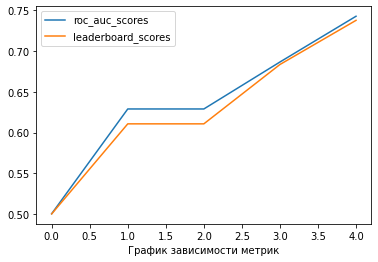

In [57]:
df.plot()
plt.xlabel('График зависимости метрик')
None

Таким образом, значения на кросс-валидации немного лучше, чем на лидерборде, самого лучшего результата удалось добиться используя все признаки и модель LogisticRegressionCV.